# Detecting return trip

Sometimes, when you have many real-data trajectories, you want to detect the return trips. This tutorial is going to show how to split and reverse one half of it in order to keep the same directions for all the trajectories. The algorithm is based on the comparison of trajectories: the return point corresponds to the point which divides the trace in two and whose distance between the two is the smallest. In tracklib, the function to do this is:
<br/>
<div class="alert alert-block alert-info" style="padding:1em">
    
```python
  collection = tkl.splitReturnTripExhaustive(trace)
```

</div>



## As usual, let's start by defining our environment

The first task is only useful for the online notebook and import the local tracklib code source. It's not necessary if tracklib is installed from PyPI.

In [1]:
import os
import sys

# Import de tracklib
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

The following two imports are necessary for the tutorial:

In [2]:
# Matplotlib to create visualizations
import matplotlib.pyplot as plt

# Import tracklib library
import tracklib as tkl

Let's add a function that draws a track, its starting point (S) and its end point (E)

In [3]:
def displayTrack(track, ax, color, dx, dy):
    track.plot(color + '-')
    track.plotFirstObs(color=color, text='S', dx=dx, dy=dy, append=ax)
    track.plotLastObs (color=color, text='E', dx=dx, dy=dy, append=ax)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title('')

## Loading two tracks

The static method *readFromGpx* returns the collection of tracks readed from the GPX file. At the moment, we keep the TrackCollection as data structure. We take this opportunity to transform geographic coordinates in a planar system.

Number of tracks: 1
Number of tracks: 1


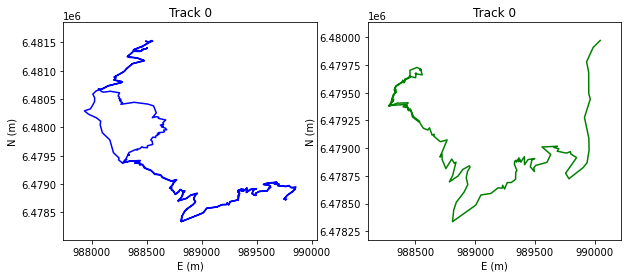

In [4]:
tkl.ObsTime.setReadFormat("4Y-2M-2DT2h:2m:2sZ")

PATH = '../../../data/gpx/456.gpx'
collection1 = tkl.TrackReader.readFromGpx(path=PATH, srid='GEO', type='trk')
collection1.toENUCoords(2154)
print ('Number of tracks: ' + str(collection1.size()))

PATH = '../../../data/gpx/457.gpx'
collection2 = tkl.TrackReader.readFromGpx(path=PATH, srid='GEO', type='trk')
collection2.toENUCoords(2154)
print ('Number of tracks: ' + str(collection2.size()))

# -------------------------------------------------------------------------
# Tracks are drawn in two separate windows
plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid((1, 2), (0, 0))
collection1[0].plot('b-', append=ax1)
ax2 = plt.subplot2grid((1, 2), (0, 1))
collection2[0].plot('g-', append=ax2)

## Zoom in on a real round trip portion

Note that in the previous figure, tracks do a return trip only on a small part of the line. So, extracted tracks abiding by geometrical shape constraint are cut and returned in the next stage below.

<Figure size 432x288 with 0 Axes>

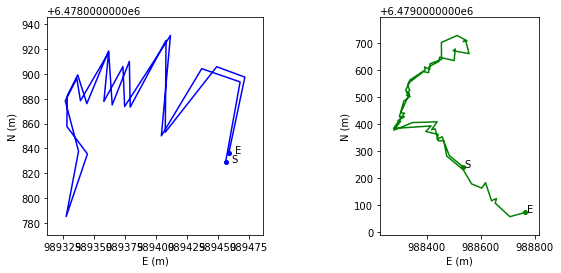

In [5]:
fig = plt.figure()

pt1 = tkl.ENUCoords(989370, 6478892, 1980)
circle1 = tkl.Circle(pt1, 120)
c1 = tkl.Constraint(shape = circle1, mode = tkl.MODE_CROSSES, type = tkl.TYPE_CUT_AND_SELECT)
collection1 = c1.select(collection1)
trace1 = collection1[0]

pt2 = tkl.ENUCoords(988439, 6479534)
circle2 = tkl.Circle(pt2, 600)
c2 = tkl.Constraint(shape = circle2, mode = tkl.MODE_CROSSES, type = tkl.TYPE_CUT_AND_SELECT)
collection2 = c2.select(collection2)
trace2 = collection2[0]

# -------------------------------------------------------------------------
# Tracks are drawn in two separate windows
plt.figure(figsize=(10, 4))
ax1 = plt.subplot2grid((1, 2), (0, 0))
displayTrack(trace1, ax1, 'b', 5, 0)
ax2 = plt.subplot2grid((1, 2), (0, 1))
displayTrack(trace2, ax2, 'g', 5, 0)

## Split the track in half


### Step 1: middle point detection

We cut along the point corresponds to the point which divides the trace in two and whose distance between the two is the smallest with the distance between DTW pairs.

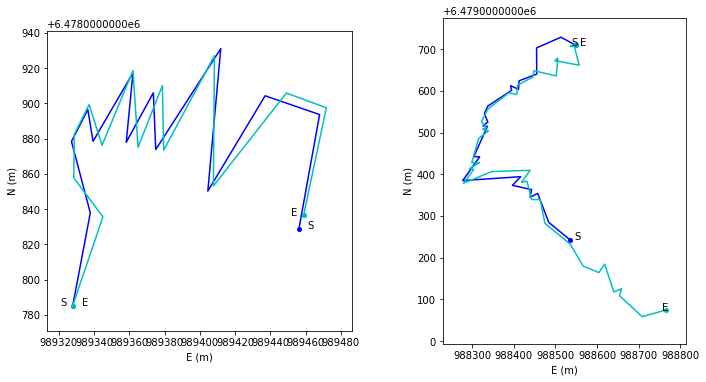

In [6]:
split1 = tkl.splitReturnTripExhaustive(trace1, verbose=False)
trace11 = split1[0]
trace12 = split1[1]

split2 = tkl.splitReturnTripExhaustive(trace2, verbose=False)
trace21 = split2[0]
trace22 = split2[1]

# On dessine
plt.figure(figsize=(12, 6))

ax1 = plt.subplot2grid((1, 2), (0, 0))
displayTrack(trace11, ax1, 'b', 5, 0)
displayTrack(trace12, ax1, 'c', -7, 0)

ax2 = plt.subplot2grid((1, 2), (0, 1))
displayTrack(trace21, ax2, 'b', 10, 0)
displayTrack(trace22, ax2, 'c', -10, 0)

### Step 2: is it a real return trip ?

This ensures that the surface area measurement of the total displacement area between the two tracks divided by the average of the lengths is below a threshold to be defined. If this is the case, we split. 

In [7]:
d1 = tkl.compare(trace11, trace12, tkl.MODE_COMPARISON_AREAL)
if d1 < 1:
    print ('We split track 1.')
else:
    print ("We don't split track 1.")

d2 = tkl.compare(trace21, trace22, tkl.MODE_COMPARISON_AREAL)
if d2 < 1:
    print ('We split track 2.')
else:
    print ("We don't split track 2.")


We split track 1.
We split track 2.


### Step 3: reverse the second half of the track in order to keep the same direction

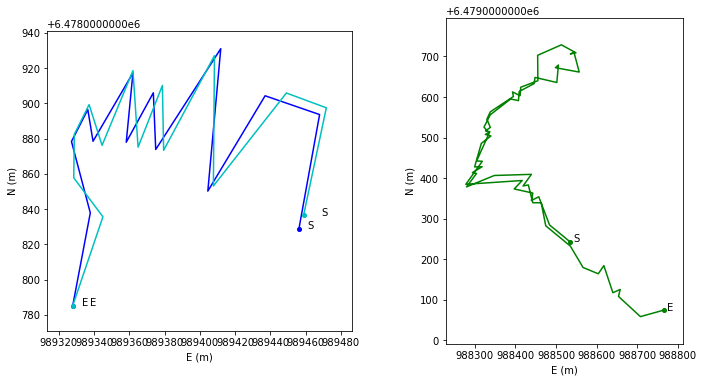

In [8]:
trace12 = trace12.reverse()

# On dessine
plt.figure(figsize=(12, 6))

ax1 = plt.subplot2grid((1, 2), (0, 0))
displayTrack(trace11, ax1, 'b', 5, 0)
displayTrack(trace12, ax1, 'c', 10, 0)

ax2 = plt.subplot2grid((1, 2), (0, 1))
displayTrack(trace2, ax2, 'g', 8, 0)